<a href="https://colab.research.google.com/github/SLVmain/Deep_Learning/blob/main/HW_12_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Ознакомьтесь с датасетом образцов эмоциональной речи

    **Toronto emotional speech set (TESS)**:

    https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP2/E8H2MF

    Ссылка для загрузки данных: https://storage.googleapis.com/datasets_ai/Base/12_audio/dataverse_files.zip

2. Разберите датасет;
3. Подготовьте и разделите данные на обучающие и тестовые;
4. Разработайте классификатор, показывающий на тесте точность распознавания эмоции не менее 98%;
5. Ознакомьтесь с другим датасетом похожего содержания

    **Surrey Audio-Visual Expressed Emotion (SAVEE)**:

    https://www.kaggle.com/ejlok1/surrey-audiovisual-expressed-emotion-savee

    Ссылка для загрузки данных: https://storage.googleapis.com/datasets_ai/Base/12_audio/archive.zip

6. Прогоните обученный классификатор на файлах из датасета **SAVEE** по вашему выбору;
7. Сделайте выводы.

In [ ]:
# Массивы
import numpy as np
import pandas as pd
# Отрисовка графиков
import matplotlib.pyplot as plt

# Связь с google диском
from google.colab import drive

# Загрузка из google облака
import gdown

# Преобразование категориальных данных в one hot encoding
from tensorflow.keras.utils import to_categorical

# Работа с папками и файлами
import os

# Утилиты работы со временем
import time

# Работа со случайными числами
import random

# Математические функции
import math

# Сохранение и загрузка структур данных Python
import pickle

# Параметризация аудио
import librosa

# Оптимизаторы для обучения моделей
from tensorflow.keras.optimizers import Adam, RMSprop

# Конструирование и загрузка моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model, load_model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

# Разбиение на обучающую и проверочную выборку
from sklearn.model_selection import train_test_split

# Кодирование категориальных меток, нормирование числовых данных
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

import librosa                            # Параметризация аудио
import librosa.display                    # Визуализация аудио
import matplotlib.pyplot as plt           # Отрисовка графиков
import IPython.display as ipd             # Проигрывание аудио в colab
import gdown                              # Загрузка датасетов из облака

# Нормирование сигнала
from sklearn.preprocessing import minmax_scale, scale

%matplotlib inline

In [ ]:
# Загрузка датасета из облака
gdown.download(' https://storage.googleapis.com/datasets_ai/Base/12_audio/dataverse_files.zip', None, quiet=True)

'dataverse_files.zip'

In [ ]:
# Распаковка архива на локальный диск colab
!unzip -qo dataverse_files.zip

In [ ]:
ls

In [ ]:
def load_audio(audio_path,       # путь к файлу с аудио
               show_text=True,   # показывать ли текстовую сводку по аудио
               show_player=True  # выводить ли проигрыватель в ячейку
               ):
    # Загрузка аудиофайла, на выходе: 
    # x  - массив данных временного ряда аудио
    # sr - частота дискретизации временного ряда
    x, sr = librosa.load(audio_path)
    
    if show_text:
        # Вывод текстовых данных о сигнале
        print(f'Типы данных x и sr: {type(x)}, {type(sr)}')
        print(f'Форма данных x: {x.shape}, sr = {sr}')
        print('Продолжительность сигнала:', round(x.shape[0]/sr), 'с.\n')

    if show_player:
        # Вывод проигрывателя в ячейку colab
        ipd.display(ipd.Audio(audio_path))

    # Возврат загруженных данных для дальнейшего использования
    return x, sr

In [ ]:
# Загрузка файла примера
x, sr = load_audio('YAF_five_angry.wav')

Типы данных x и sr: <class 'numpy.ndarray'>, <class 'int'>
Форма данных x: (55200,), sr = 22050
Продолжительность сигнала: 3 с.



In [ ]:
tess_dir = '/content/'
labels = []
file_paths = []
for filename in os.listdir(tess_dir):
  if filename.split('.')[-1] == 'wav':
      file_paths.append(os.path.join(tess_dir, filename))
      label = filename.split('_')[-1] 
      label = label.split('.')[0]
      if label == 'ps':
        labels.append('surpise')
      else: 
        labels.append(label.lower())
    
print(labels[:10])
print(file_paths[:10])
print(len(labels))
print(len(file_paths))

['disgust', 'fear', 'fear', 'angry', 'fear', 'angry', 'happy', 'happy', 'disgust', 'sad']
['/content/OAF_choice_disgust.wav', '/content/OAF_bite_fear.wav', '/content/YAF_jar_fear.wav', '/content/OAF_merge_angry.wav', '/content/OAF_sure_fear.wav', '/content/YAF_hush_angry.wav', '/content/OAF_witch_happy.wav', '/content/YAF_cool_happy.wav', '/content/YAF_road_disgust.wav', '/content/OAF_shack_sad.wav']
2800
2800


In [ ]:
classes = list(set(labels))
classes

['fear', 'sad', 'neutral', 'happy', 'angry', 'disgust', 'surpise']

In [ ]:
num_classes = len(classes)
num_classes

7

In [ ]:
df = pd.DataFrame()
df['audio'] = file_paths 
df['label'] = labels 
df.head()

,audio,label
0,/content/OAF_choice_disgust.wav,disgust
1,/content/OAF_bite_fear.wav,fear
2,/content/YAF_jar_fear.wav,fear
3,/content/OAF_merge_angry.wav,angry
4,/content/OAF_sure_fear.wav,fear


In [ ]:
df['label'].value_counts()

disgust    400
fear       400
angry      400
happy      400
sad        400
neutral    400
surpise    400
Name: label, dtype: int64

In [ ]:
# Установка констант
FILE_DIR = tess_dir                    # Папка с файлами датасета
CLASS_LIST = os.listdir(FILE_DIR)         # Список классов, порядок меток не определен!
CLASS_LIST = classes                       # Сортировка списка классов для фиксации порядка меток
CLASS_COUNT = len(classes)             # Количество классов
CLASS_FILES = 400                         # Общее количество файлов в каждом классе
FILE_INDEX_TRAIN_SPLIT = 340               # Количество файлов каждого класса на основной набор
VALIDATION_SPLIT = 0.1                    # Доля проверочной выборки в основном наборе
DURATION_SEC = 30                         # Анализируемая длительность аудиосигнала
N_FFT = 8192                              # Размер окна преобразования Фурье для расчета спектра
HOP_LENGTH = 512                          # Объем данных для расчета одного набора признаков

In [ ]:
def get_features(y,                     # волновое представление сигнала
                 sr,                    # частота дискретизации сигнала y
                 n_fft=N_FFT,           # размер скользящего окна БПФ
                 hop_length=HOP_LENGTH  # шаг скользящего окна БПФ
                 ):
    # Вычисление различных параметров (признаков) аудио
    
    # Хромаграмма
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Мел-кепстральные коэффициенты
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Среднеквадратическая амплитуда
    rmse = librosa.feature.rms(y=y, hop_length=hop_length)
    # Спектральный центроид
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Ширина полосы частот
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Спектральный спад частоты
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Пересечения нуля
    zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)
    
    # Сборка признаков в общий список:
    # На один файл несколько векторов признаков, количество определяется
    # продолжительностью аудио и параметром hop_length в функциях расчета признаков
    features = {'rmse': rmse, 
                'spct': spec_cent, 
                'spbw': spec_bw,
                'roff': rolloff,
                'zcr' : zcr,
                'mfcc': mfcc,
                'stft': chroma_stft}

    return features

In [ ]:
# Функция объединения признаков в набор векторов

def stack_features(feat  # словарь признаков, отдельные векторы по ключу каждого признака
                   ):
    features = None
    for v in feat.values():
        features = np.vstack((features, v)) if features is not None else v

    return features.T

In [ ]:
# Проверка параметризации одного произведения
y, sr = librosa.load('/content/OAF_choice_disgust.wav', mono=True, duration=DURATION_SEC)
features = get_features(y, sr)

In [ ]:
print(features)

In [ ]:
classes

['fear', 'sad', 'neutral', 'happy', 'angry', 'disgust', 'surpise']

In [ ]:
label_index = classes.index(label)

In [ ]:
# Функция формирования набора признаков и метки класса для аудиофайла

def get_feature_list_from_file(label_index, song_name,    # имя аудиофайла
                               duration_sec  # длительность аудио в секундах
                               ):
    # Загрузка в y первых duration_sec секунд аудиосигнала
    y, sr = librosa.load(song_name, mono=True, duration=duration_sec)

    # Извлечение параметров из аудиосигнала
    features = get_features(y, sr)
    feature_set = stack_features(features)

    # Перевод номера класса в one hot encoding
    y_label = to_categorical(label_index, CLASS_COUNT)
    

    return feature_set, y_label

In [ ]:
# Функция формирования подвыборки признаков и меток класса для одного файла

def process_file(label_index, song_name,   # индекс (порядковый номер) аудиофайла в папке класса
                 duration_sec  # длительность аудио в секундах
                 ):
    x_list = []
    y_list = []
    
    
    # Выборка признаков
    feature_set, y_label = get_feature_list_from_file(label_index, song_name,
                                                        duration_sec)

    # Добавление данных в X
    for j in range(feature_set.shape[0]):
        x_list.append(feature_set[j])
        y_list.append(y_label)

    
    return np.array(x_list).astype('float32'), np.array(y_list).astype('float32')
           

In [ ]:
# Функция формирования набора данных из файлов всех классов по диапазону номеров файлов

def extract_data(duration_sec=DURATION_SEC):  # длительность аудио в секундах
                 

    # Списки для последовательностей входных данных и меток класса
    x_data = None
    y_data = None

    # Фиксация времени старта формирования выборки
    curr_time = time.time()

    #Проходим по всем файлам
    for i in range(len(file_paths)):
      label = labels[i]
      label_index = classes.index(label)
      song_name = file_paths[i]

      file_x_data, file_y_data = process_file(label_index, song_name, duration_sec)
      x_data = file_x_data if x_data is None else np.vstack([x_data, file_x_data])
      y_data = file_y_data if y_data is None else np.vstack([y_data, file_y_data])
      

    # Возврат массивов набора данных
    return x_data, y_data

In [ ]:
# Формирование тренировочного (основного) набора данных
x_train_data, y_train_data = extract_data()

In [ ]:
# Вывод формы данных обучающего набора
print(x_train_data.shape, x_train_data.dtype)
print(y_train_data.shape, y_train_data.dtype)

(249251, 37) float32
(249251, 7) float32


In [ ]:
# Нормирование признаков в соответствии со стандартным нормальным распределением
x_scaler = StandardScaler()
x_train_data_scaled = x_scaler.fit_transform(x_train_data)

In [ ]:
# Разделение набора данных на обучающую и проверочную выборки
# Параметр stratify указывает метки классов, по которым происходит балансировка разделения
x_train, x_val, y_train, y_val = train_test_split(x_train_data_scaled,
                                                  y_train_data,
                                                  stratify=y_train_data,
                                                  test_size=VALIDATION_SPLIT)

In [ ]:
# Проверка нормирования
print(x_train[0])

[ 1.0924938   0.20390478  1.6140232   1.0453284  -0.5445132   1.0023398
 -0.67308897  0.24845941  0.8425158   0.29092658 -1.1807836  -0.11371254
  0.03153326  0.37045544  0.38594496 -0.28797844  0.09993646 -0.11244014
 -0.61470276 -0.31233865 -0.39392805  0.47172543 -0.41248903 -1.9895899
 -0.5625732  -0.92038786 -0.23949236  2.0590641   0.26673123 -0.77936524
 -0.90815353 -0.99241656 -0.9849579  -0.8739785  -0.7078637  -0.8568123
 -0.88885164]


In [ ]:
# Проверка формы и типа данных обучающей и проверочной выборок
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print()
print(x_val.shape, x_val.dtype)
print(y_val.shape, y_val.dtype)

(224325, 37) float32
(224325, 7) float32

(24926, 37) float32
(24926, 7) float32


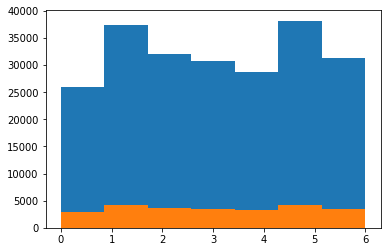

In [ ]:
# Проверка сбалансированности выборок по классам
plt.hist(np.argmax(y_train, axis=1), CLASS_COUNT)
plt.hist(np.argmax(y_val, axis=1), CLASS_COUNT)
plt.show()

##Модель нейронной сети

In [ ]:
# Функция сборки и обучения классификатора на полносвязных слоях

def create_train_classifier(in_shape,       # форма входных данных модели
                            epochs=50,      # количество эпох обучения
                            batch_size=128  # размер батча
                            ):
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_shape=in_shape))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(254, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(CLASS_COUNT, activation='softmax'))

    # Компиляция модели
    model.compile(optimizer=Adam(lr=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model.summary()

    # Обучение модели
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графика точности распознавания на обучающей и проверочной выборках
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
    plt.plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
    plt.xticks(range(epochs))
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()

    return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              38912     
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 batch_normalization_3 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                      

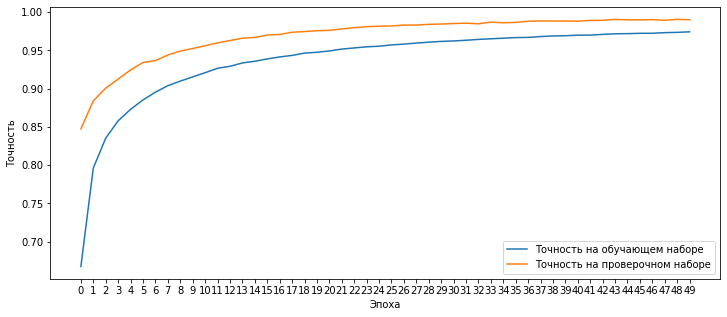

In [ ]:
model = create_train_classifier(x_train.shape[1:])

In [ ]:
history = model.fit(x_train,
                        y_train,
                        epochs=20,
                        batch_size=216,
                        validation_data=(x_val, y_val))

Epoch 1/20
1039/1039 [==============================] - 5s 4ms/step - loss: 0.0596 - accuracy: 0.9791 - val_loss: 0.0257 - val_accuracy: 0.9922
Epoch 2/20
1039/1039 [==============================] - 5s 4ms/step - loss: 0.0575 - accuracy: 0.9796 - val_loss: 0.0255 - val_accuracy: 0.9918
Epoch 3/20
1039/1039 [==============================] - 5s 4ms/step - loss: 0.0582 - accuracy: 0.9793 - val_loss: 0.0244 - val_accuracy: 0.9925
Epoch 4/20
1039/1039 [==============================] - 5s 4ms/step - loss: 0.0579 - accuracy: 0.9795 - val_loss: 0.0251 - val_accuracy: 0.9921
Epoch 5/20
1039/1039 [==============================] - 5s 4ms/step - loss: 0.0567 - accuracy: 0.9799 - val_loss: 0.0251 - val_accuracy: 0.9924
Epoch 6/20
1039/1039 [==============================] - 5s 4ms/step - loss: 0.0549 - accuracy: 0.9805 - val_loss: 0.0233 - val_accuracy: 0.9932
Epoch 7/20
1039/1039 [==============================] - 5s 4ms/step - loss: 0.0553 - accuracy: 0.9803 - val_loss: 0.0227 - val_accuracy:

Заданная точность 0,98 достигнута

In [ ]:
# Функция оценки точности модели на заданной выборке

def eval_model(model,  # обученная модель нейронной сети
               x,      # входные данные
               y_true  # выходные данные (верные ответы)
               ):
    loss, acc = model.evaluate(x, y_true)
    print(f'Ошибка: {loss}, точность: {acc}')

    # Построение матрицы ошибок
    y_pred = model.predict(x)
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Матрица ошибок нормализованная')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
    disp.plot(ax=ax)
    plt.show()    

779/779 [==============================] - 2s 2ms/step - loss: 0.0187 - accuracy: 0.9941
Ошибка: 0.018726976588368416, точность: 0.9941025376319885


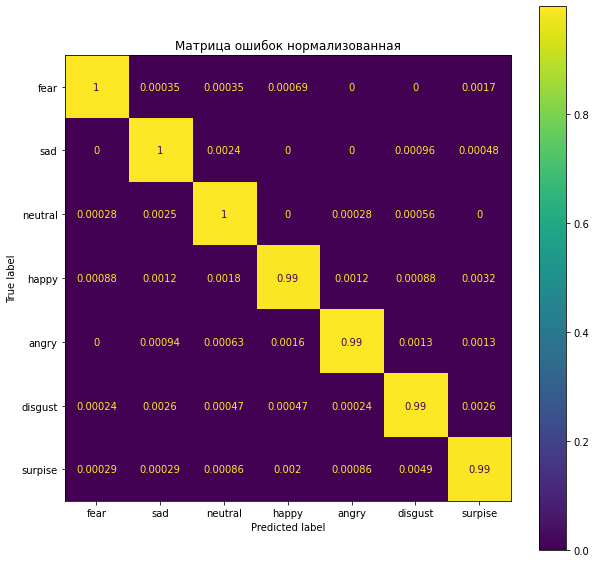

In [ ]:
eval_model(model, x_val, y_val)

5. Ознакомьтесь с другим датасетом похожего содержания

    **Surrey Audio-Visual Expressed Emotion (SAVEE)**:

    https://www.kaggle.com/ejlok1/surrey-audiovisual-expressed-emotion-savee

    Ссылка для загрузки данных: https://storage.googleapis.com/datasets_ai/Base/12_audio/archive.zip

6. Прогоните обученный классификатор на файлах из датасета **SAVEE** по вашему выбору;
7. Сделайте выводы.

In [ ]:
# Загрузка датасета из облака
gdown.download('https://storage.googleapis.com/datasets_ai/Base/12_audio/archive.zip', None, quiet=True)

'archive.zip'

In [ ]:
# Распаковка архива на локальный диск colab
!unzip -qo archive.zip -d savee

In [ ]:
s_dir = '/content/savee/ALL/'

In [ ]:
label_s = []
file_path_s = []

for filename in os.listdir(s_dir):
    file_path_s.append(s_dir + filename)
    part = filename.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        label_s.append('angry')
    elif ele=='d':
        label_s.append('disgust')
    elif ele=='f':
        label_s.append('fear')
    elif ele=='h':
        label_s.append('happy')
    elif ele=='n':
        label_s.append('neutral')
    elif ele=='sa':
        label_s.append('sad')
    else:
        label_s.append('surprise')
        

In [ ]:
print(label_s[:10])
print(file_path_s[:10])
print(len(label_s))
print(len(file_path_s))

['fear', 'angry', 'neutral', 'surprise', 'fear', 'fear', 'disgust', 'angry', 'surprise', 'neutral']
['/content/savee/ALL/JE_f04.wav', '/content/savee/ALL/JE_a12.wav', '/content/savee/ALL/KL_n19.wav', '/content/savee/ALL/KL_su08.wav', '/content/savee/ALL/JK_f12.wav', '/content/savee/ALL/KL_f11.wav', '/content/savee/ALL/JE_d07.wav', '/content/savee/ALL/JK_a06.wav', '/content/savee/ALL/DC_su15.wav', '/content/savee/ALL/JE_n14.wav']
480
480


In [ ]:
classes_s = set(label_s)
print(len(classes_s))
print(classes_s)

7
{'fear', 'sad', 'neutral', 'happy', 'angry', 'surprise', 'disgust'}


In [ ]:
classes_s = list(classes_s)

In [ ]:
# Загрузка файла примера
x, sr = load_audio(file_path_s[90])

Типы данных x и sr: <class 'numpy.ndarray'>, <class 'int'>
Форма данных x: (93928,), sr = 22050
Продолжительность сигнала: 4 с.



In [ ]:
# Функция формирования набора признаков и метки класса для аудиофайла

def get_feature_list_from_file_s(label_index, song_name,    # имя аудиофайла
                               duration_sec  # длительность аудио в секундах
                               ):
    # Загрузка в y первых duration_sec секунд аудиосигнала
    y, sr = librosa.load(song_name, mono=True, duration=duration_sec)

    # Извлечение параметров из аудиосигнала
    features = get_features(y, sr)
    feature_set = stack_features(features)

    # Перевод номера класса в one hot encoding
    y_label = to_categorical(label_index, CLASS_COUNT)
    

    return feature_set, y_label

In [ ]:
# Функция формирования подвыборки признаков и меток класса для одного файла

def process_file_s(label_index, song_name,   # индекс (порядковый номер) аудиофайла в папке класса
                 duration_sec  # длительность аудио в секундах
                 ):
    x_list = []
    y_list = []
    
    
    # Выборка признаков
    feature_set, y_label = get_feature_list_from_file_s(label_index, song_name,
                                                        duration_sec)

    # Добавление данных в X
    for j in range(feature_set.shape[0]):
        x_list.append(feature_set[j])
        y_list.append(y_label)

    
    return np.array(x_list).astype('float32'), np.array(y_list).astype('float32')
           

In [ ]:
classes_s = ['fear', 'sad', 'neutral', 'happy', 'angry', 'disgust', 'surprise'] #берем порядок классов так, как они шли в обучающем датасете

In [ ]:
# Функция формирования набора данных из файлов всех классов по диапазону номеров файлов

def extract_data_s(duration_sec=DURATION_SEC):  # длительность аудио в секундах
                 

    # Списки для последовательностей входных данных и меток класса
    x_data = None
    y_data = None

    # Фиксация времени старта формирования выборки
    curr_time = time.time()

    #Проходим по всем файлам
    for i in range(len(file_path_s)):
      label = label_s[i]
      label_index = classes_s.index(label) #берем метки классов из модели
      song_name = file_path_s[i]

      file_x_data, file_y_data = process_file_s(label_index, song_name, duration_sec)
      x_data = file_x_data if x_data is None else np.vstack([x_data, file_x_data])
      y_data = file_y_data if y_data is None else np.vstack([y_data, file_y_data])
      

    # Возврат массивов набора данных
    return x_data, y_data

In [ ]:
# Формирование тренировочного (основного) набора данных
x_data_s, y_data_s = extract_data_s()

In [ ]:
# Вывод формы данных обучающего набора
print(x_data_s.shape, x_data_s.dtype)
print(y_data_s.shape, y_data_s.dtype)

(79609, 37) float32
(79609, 7) float32


In [ ]:
# Нормирование признаков в соответствии со стандартным нормальным распределением
x_scaler = StandardScaler()
x_data_s_scaled = x_scaler.fit_transform(x_data_s)

2488/2488 [==============================] - 5s 2ms/step - loss: 11.0345 - accuracy: 0.1544
Ошибка: 11.034496307373047, точность: 0.15442977845668793


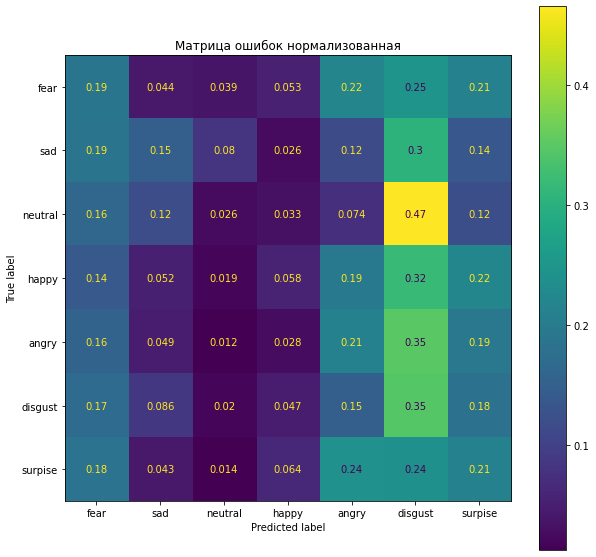

In [ ]:
# Оценка точности сети на тестовой выборке
eval_model(model, x_data_s_scaled, y_data_s)

модель плохо отработала на датасете savee, думаю, потому что первый датасет записан женскими голосами, а второй - мужскими